In [1]:
# import libraries 
import os
import numpy as np 

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten 

In [2]:
# fetch images count from folders
count = 0
dirs = os.listdir('flowers_images/')
for dir in dirs:
    files = list(os.listdir('flowers_images/'+dir))
    print(dir + ' folder has '+ str(len(files)) + ' images')
    count = count + len(files)

print('flower_images folder has ' + str(count) + ' images')

daisy folder has 501 images
dandelion folder has 646 images
roses folder has 497 images
sunflowers folder has 495 images
tulips folder has 607 images
flower_images folder has 2746 images


In [3]:
base_dir = 'flowers_images/'
img_size = 180
batch = 32

In [4]:
# load images into arrays as dataset
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir, seed = 123, validation_split = 0.2, subset = 'training', 
                                                       batch_size = batch, image_size = (img_size, img_size))

val_ds = tf.keras.utils.image_dataset_from_directory(base_dir, seed = 123, validation_split = 0.2, subset = 'validation', 
                                                       batch_size = batch, image_size = (img_size, img_size))

Found 2746 files belonging to 5 classes.
Using 2197 files for training.
Found 2746 files belonging to 5 classes.
Using 549 files for validation.


In [5]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

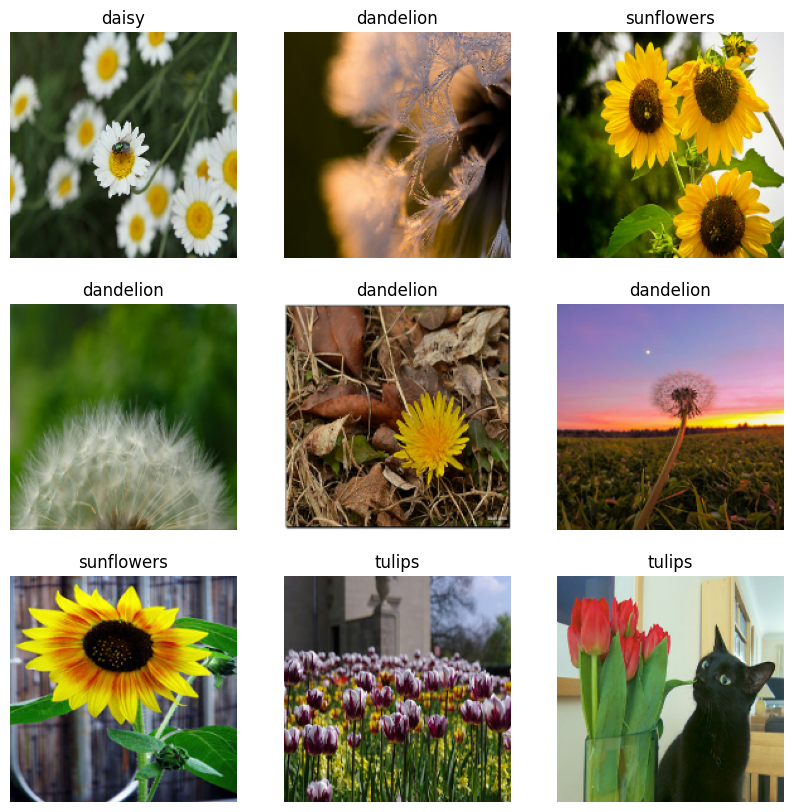

In [6]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1): 
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [9]:
# data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

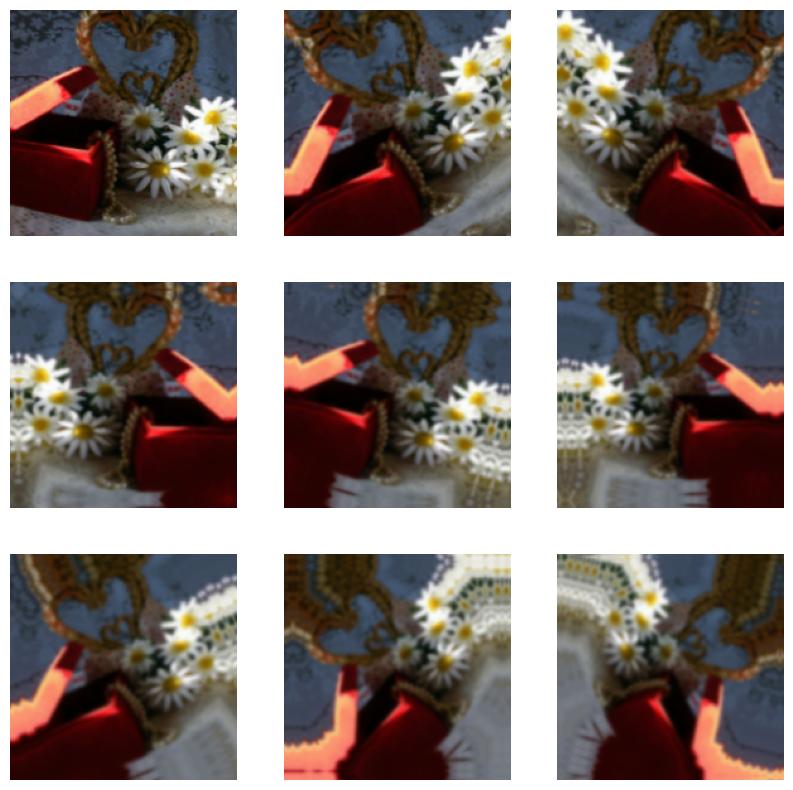

In [10]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1): 
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [11]:
# model creation
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 90, 90, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 30976)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.8981 - loss: 0.2962 - val_accuracy: 0.7213 - val_loss: 1.1423
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.8915 - loss: 0.3230 - val_accuracy: 0.7031 - val_loss: 1.0167
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.9188 - loss: 0.2320 - val_accuracy: 0.6794 - val_loss: 1.2727
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9062 - loss: 0.2704 - val_accuracy: 0.6922 - val_loss: 1.1839
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.9130 - loss: 0.2592 - val_accuracy: 0.7049 - val_loss: 1.1934
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.9063 - loss: 0.2458 - val_accuracy: 0.7304 - val_loss: 1.1137
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9349 - loss: 0.1810 - val_accuracy: 0.6976 - val_loss: 1.2633
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.9008 - loss: 0.2528 - val_accu

In [22]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The image belongs to ' + flower_names[np.argmax(result)] + ' with a score of ' + str(np.max(result)*100)
    return outcome

In [23]:
classify_images('sample/tulip.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


'The image belongs to tulips with a score of 100.0'

In [24]:
model.save('Flower_Recog_Model.h5')